#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
state = 12345

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data.info())
display(data.describe())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


num_orders    0
dtype: int64

### Вывод:

- Информация о структуре данных - двумерная(DataFrame);
- таблица имеет 26496 строк и 1 столбец; 
- присутствуют названия столбцов и количество ненулевых значений;
- в таблице присутствуют значения типов int(1 столбeц);
- использование памяти.

Пропуски отсутствуют. Изначально первый столбец сразу перевели из типа object в тип datetime и сделали его индексом.

Сделаем ресемплирование:

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [5]:
data.index.is_monotonic

True

### Вывод:

Ресемплирование выполнено и данные находятя в хронологическом порядке.

## Анализ

<AxesSubplot:xlabel='datetime'>

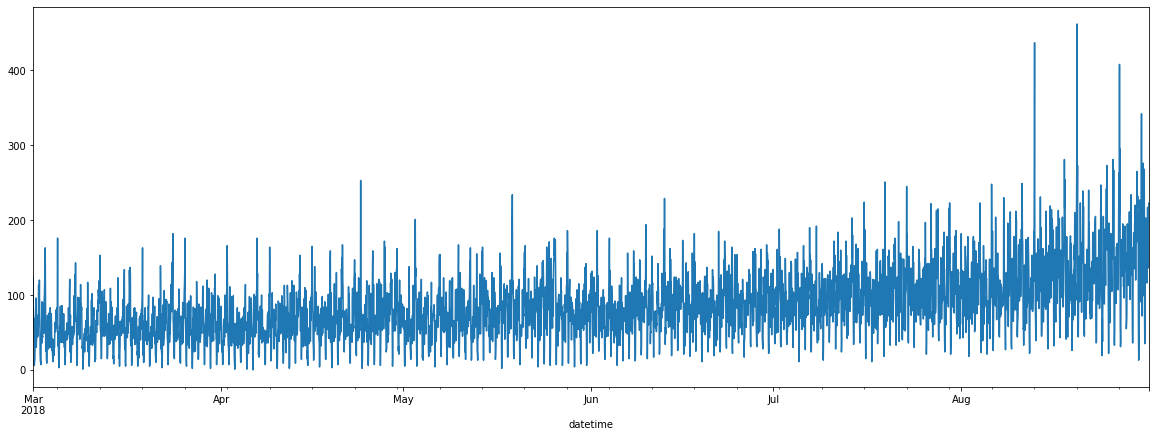

In [6]:
data['num_orders'].plot(figsize=(20,7))

По данному графику не особо что-то понятно, рассмотрим подробнее:

Сделаем декомпозицию для проверки тренда и сезонности:

In [7]:
decomposed = seasonal_decompose(data)

<AxesSubplot:title={'center':'Seasonality'}, xlabel='datetime'>

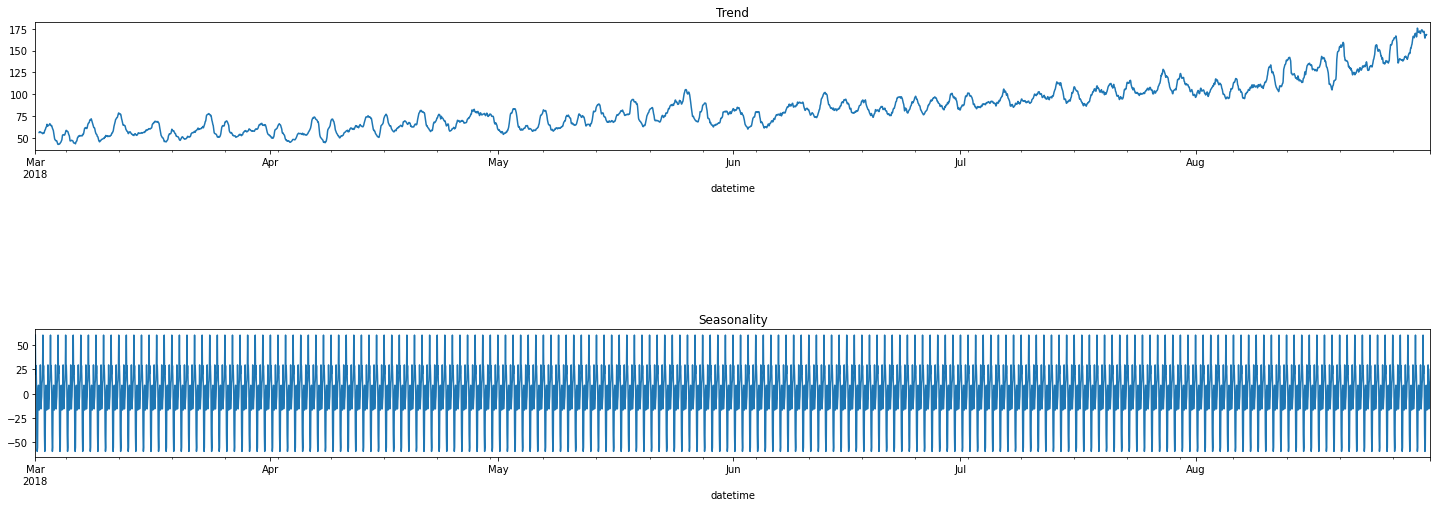

In [8]:
plt.figure(figsize=(25, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

Присутствует восходящий тренд и сезонность.

Можно рассмотреть сезонность в течение недели:

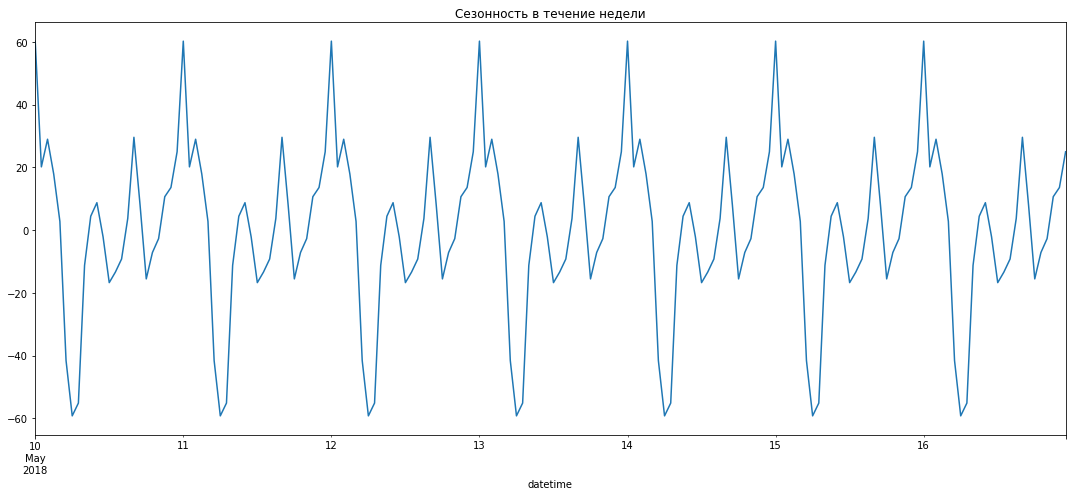

In [9]:
plt.figure(figsize=(15, 7))
decomposed.seasonal['2018-05-10':'2018-05-16'].plot(ax=plt.gca())
plt.title('Сезонность в течение недели')
plt.tight_layout()

Можно заметить, что каждый день есть часы когда такси заказывают часто и когда редко, значит посмотрим сезонность по часам одного дня:

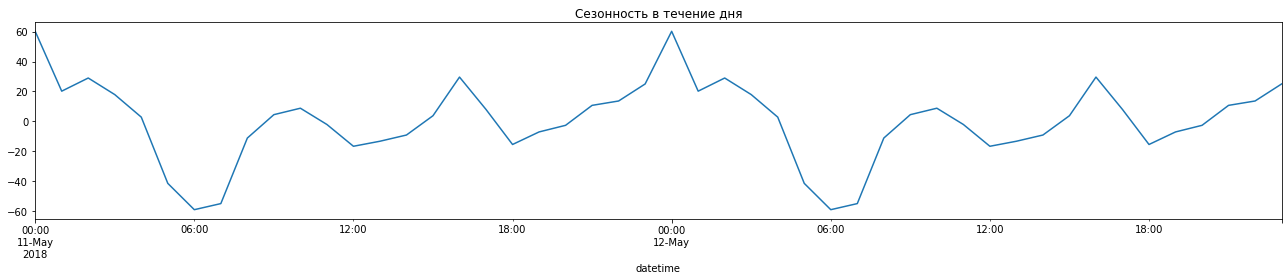

In [10]:
plt.figure(figsize=(18, 4))
decomposed.seasonal['2018-05-11':'2018-05-12'].plot(ax=plt.gca())
plt.title('Сезонность в течение дня')
plt.tight_layout()

По графику видно, что реже всего заказывают такси в 6 утра и чаще всего в 12 ночи.

## Обучение

Найдем скользящее среднее вызовом функции rolling().mean() и стандартное скользящее отклонение - rolling().std():

<AxesSubplot:xlabel='datetime'>

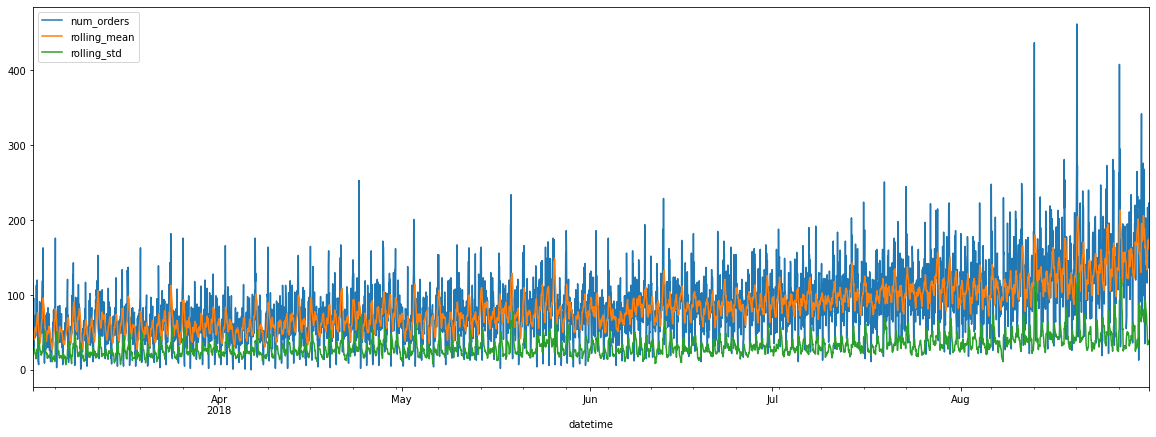

In [11]:
data['rolling_mean'] = data['num_orders'].rolling(10).mean()
data['rolling_std'] = data['num_orders'].rolling(10).std()
data = data.dropna()
data.plot(figsize=(20,7))

Временной ряд нестационарный, так как среднее значение и стандартное отклонение увеличиваются со временем.

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df_new = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_new

make_features(data, 7, 7)

,num_orders,rolling_mean,rolling_std
datetime,,,
2018-03-01 09:00:00,69,52.5,37.426224
2018-03-01 10:00:00,64,46.5,28.414589
2018-03-01 11:00:00,96,47.6,30.225817
2018-03-01 12:00:00,30,43.5,29.470324
2018-03-01 13:00:00,32,40.1,28.532438
...,...,...,...
2018-08-31 19:00:00,136,166.6,35.362252
2018-08-31 20:00:00,154,162.9,34.449480
2018-08-31 21:00:00,159,162.1,34.436576


In [13]:
data

,num_orders,rolling_mean,rolling_std,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,,,,
2018-03-01 09:00:00,69,NaN,37.426224,2018,3,1,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 10:00:00,64,NaN,28.414589,2018,3,1,3,10,69.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 11:00:00,96,NaN,30.225817,2018,3,1,3,11,64.0,69.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 12:00:00,30,NaN,29.470324,2018,3,1,3,12,96.0,64.0,69.0,NaN,NaN,NaN,NaN
2018-03-01 13:00:00,32,NaN,28.532438,2018,3,1,3,13,30.0,96.0,64.0,69.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.428571,35.362252,2018,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0
2018-08-31 20:00:00,154,167.428571,34.449480,2018,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0
2018-08-31 21:00:00,159,165.714286,34.436576,2018,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0


Разделим выборку на обучающую и тестовую:

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

display(features_train.shape)
display(target_train.shape)

display(features_test.shape)
display(target_test.shape)

(3959, 14)

(3959,)

(441, 14)

(441,)

### Линейная регрессия(LinearRegression)

In [15]:
tscv = TimeSeriesSplit(n_splits=5)

In [16]:
%%time

model_linreg = LinearRegression()
model_linreg.fit(features_train, target_train)
pred_linreg_train = model_linreg.predict(features_train)
mse_linreg_train = mean_squared_error(target_train, pred_linreg_train)

print('RMSE_TRAIN:',  mse_linreg_train ** 0.5)

RMSE_TRAIN: 30.426474816539486
CPU times: user 18.4 ms, sys: 4.49 ms, total: 22.8 ms
Wall time: 7.57 ms


RMSE_TRAIN: 30.426474816539486
CPU times: user 78 ms, sys: 53.1 ms, total: 131 ms
Wall time: 68.6 ms

### LightGBM(LGBMRegressor)

In [17]:
%%time

model_lgbmr = LGBMRegressor()
parametrs = {
        'boosting_type' : ['gbdt'],
        'n_estimators' : range(10, 100, 10),
        'max_depth' : range(1, 16, 2),
        'random_state' : [state],
        'verbose' : [-1],
        'force_row_wise': [True],
        'num_leaves' : [127]}
model_lgbmr_grid = GridSearchCV(model_lgbmr, parametrs, cv=tscv)
model_lgbmr_grid.fit(features_train, target_train)
pred_lgbmr_train = model_lgbmr_grid.predict(features_train)
mse_lgbmr_train = mean_squared_error(target_train, pred_lgbmr_train)
print('Лучшие гиперпараметры для модели: ', model_lgbmr_grid.best_params_)
print('RMSE_TRAIN:',  mse_lgbmr_train ** 0.5)

Лучшие гиперпараметры для модели:  {'boosting_type': 'gbdt', 'force_row_wise': True, 'max_depth': 7, 'n_estimators': 90, 'num_leaves': 127, 'random_state': 12345, 'verbose': -1}
RMSE_TRAIN: 13.510365171745718
CPU times: user 1h 19min 7s, sys: 43.1 s, total: 1h 19min 50s
Wall time: 1h 20min 15s


### Дерево решений в регрессии(DecisionTreeRegressor)

In [18]:
%%time

model_tree = DecisionTreeRegressor(random_state=state)
parametrs = {'max_depth': range (1,16, 2)}
model_tree_grid = GridSearchCV(model_tree, parametrs, cv=tscv)
model_tree_grid.fit(features_train, target_train)
pred_tree_train = model_tree_grid.predict(features_train)
mse_tree_train = mean_squared_error(target_train, pred_tree_train)

print('Глубина дерева для лучшей модели:', model_tree_grid.best_params_)
print('RMSE_TRAIN:',  mse_tree_train ** 0.5)

Глубина дерева для лучшей модели: {'max_depth': 7}
RMSE_TRAIN: 21.280667171509915
CPU times: user 644 ms, sys: 211 µs, total: 645 ms
Wall time: 712 ms


Глубина дерева для лучшей модели: {'max_depth': 7}
RMSE_TRAIN: 21.280667171509915
CPU times: user 1.14 s, sys: 16 ms, total: 1.16 s
Wall time: 1.2 s

### CatBoostRegressor

In [19]:
%%time

model_cat = CatBoostRegressor()
parametrs = {
        'n_estimators' : range(10, 100, 10),
        'verbose' : [0],
        'random_state' : [state],
        'max_depth' : range(1, 16, 2)}
model_cat_grid = GridSearchCV(model_cat, parametrs, cv=tscv)
model_cat_grid.fit(features_train, target_train)
pred_cat_train = model_cat_grid.predict(features_train)
mse_cat_train = mean_squared_error(target_train, pred_cat_train)

print('Глубина дерева и количество деревьев для лучшей модели:', model_cat_grid.best_params_)
print('RMSE_TRAIN:',  mse_cat_train ** 0.5)

Глубина дерева и количество деревьев для лучшей модели: {'max_depth': 5, 'n_estimators': 80, 'random_state': 12345, 'verbose': 0}
RMSE_TRAIN: 15.71538998937788
CPU times: user 37min 7s, sys: 20min 31s, total: 57min 38s
Wall time: 59min 29s


Глубина дерева и количество деревьев для лучшей модели: {'max_depth': 5, 'n_estimators': 70, 'random_state': 12345, 'verbose': 0}
RMSE_TRAIN: 15.803205806176077
CPU times: user 46min 20s, sys: 24min 28s, total: 1h 10min 48s
Wall time: 1h 14min 42s

### Случайный лес(RandomForestRegressor)

In [20]:
%%time

model_forest = RandomForestRegressor(random_state=state)
parametrs = {'max_depth': range (1,16, 2), 'n_estimators': range(10, 100, 10)}
model_forest_grid = GridSearchCV(model_forest, parametrs, cv=tscv)
model_forest_grid.fit(features_train, target_train)
pred_forest_train = model_forest_grid.predict(features_train)
mse_forest_train = mean_squared_error(target_train, pred_forest_train)

print('Глубина дерева и количество деревьев для лучшей модели:', model_forest_grid.best_params_)
print('RMSE_TRAIN:',  mse_forest_train ** 0.5)

Глубина дерева и количество деревьев для лучшей модели: {'max_depth': 15, 'n_estimators': 90}
RMSE_TRAIN: 8.97870019945038
CPU times: user 2min 20s, sys: 796 ms, total: 2min 21s
Wall time: 2min 22s


Глубина дерева и количество деревьев для лучшей модели: {'max_depth': 15, 'n_estimators': 80}
RMSE_TRAIN: 9.022663287015323
CPU times: user 3min 41s, sys: 1.39 s, total: 3min 43s
Wall time: 3min 44s

## Тестирование

### Линейная регрессия(LinearRegression)

In [21]:
%%time

pred_linreg_test = model_linreg.predict(features_test)
mse_linreg_test = mean_squared_error(target_test, pred_linreg_test)

print('RMSE_TEST:',  mse_linreg_test ** 0.5)

RMSE_TEST: 52.531810721647204
CPU times: user 3.74 ms, sys: 119 µs, total: 3.86 ms
Wall time: 3.25 ms


RMSE_TEST: 52.531810721647204
CPU times: user 3.16 ms, sys: 0 ns, total: 3.16 ms
Wall time: 2.63 ms

### LightGBM(LGBMRegressor)

In [22]:
%%time

pred_lgbmr_test = model_lgbmr_grid.predict(features_test)
mse_lgbmr_test = mean_squared_error(target_test, pred_lgbmr_test)

print('RMSE_TEST:',  mse_lgbmr_test ** 0.5)

RMSE_TEST: 42.87538351641644
CPU times: user 5.06 ms, sys: 172 µs, total: 5.24 ms
Wall time: 3.6 ms


### Дерево решений в регрессии(DecisionTreeRegressor)

In [23]:
%%time

pred_tree_test = model_tree_grid.predict(features_test)
mse_tree_test = mean_squared_error(target_test, pred_tree_test)

print('RMSE_TEST:',  mse_tree_test ** 0.5)

RMSE_TEST: 49.857806429992685
CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.26 ms


RMSE_TEST: 49.857806429992685
CPU times: user 4.08 ms, sys: 0 ns, total: 4.08 ms
Wall time: 3.11 ms

### CatBoostRegressor

In [24]:
%%time

pred_cat_test = model_cat_grid.predict(features_test)
mse_cat_test = mean_squared_error(target_test, pred_cat_test)

print('RMSE_TEST:',  mse_cat_test ** 0.5)

RMSE_TEST: 45.45413607444937
CPU times: user 2.02 ms, sys: 362 µs, total: 2.38 ms
Wall time: 2.1 ms


RMSE_TEST: 44.837287369984566
CPU times: user 2.49 ms, sys: 0 ns, total: 2.49 ms
Wall time: 2.18 ms

### Случайный лес(RandomForestRegressor)

In [25]:
%%time

pred_forest_test = model_forest_grid.predict(features_test)
mse_forest_test = mean_squared_error(target_test, pred_forest_test)

print('RMSE_TEST:',  mse_forest_test ** 0.5)

RMSE_TEST: 43.984237913258525
CPU times: user 16.9 ms, sys: 90 µs, total: 17 ms
Wall time: 44.2 ms


RMSE_TEST: 44.20009833563545
CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 13.8 ms

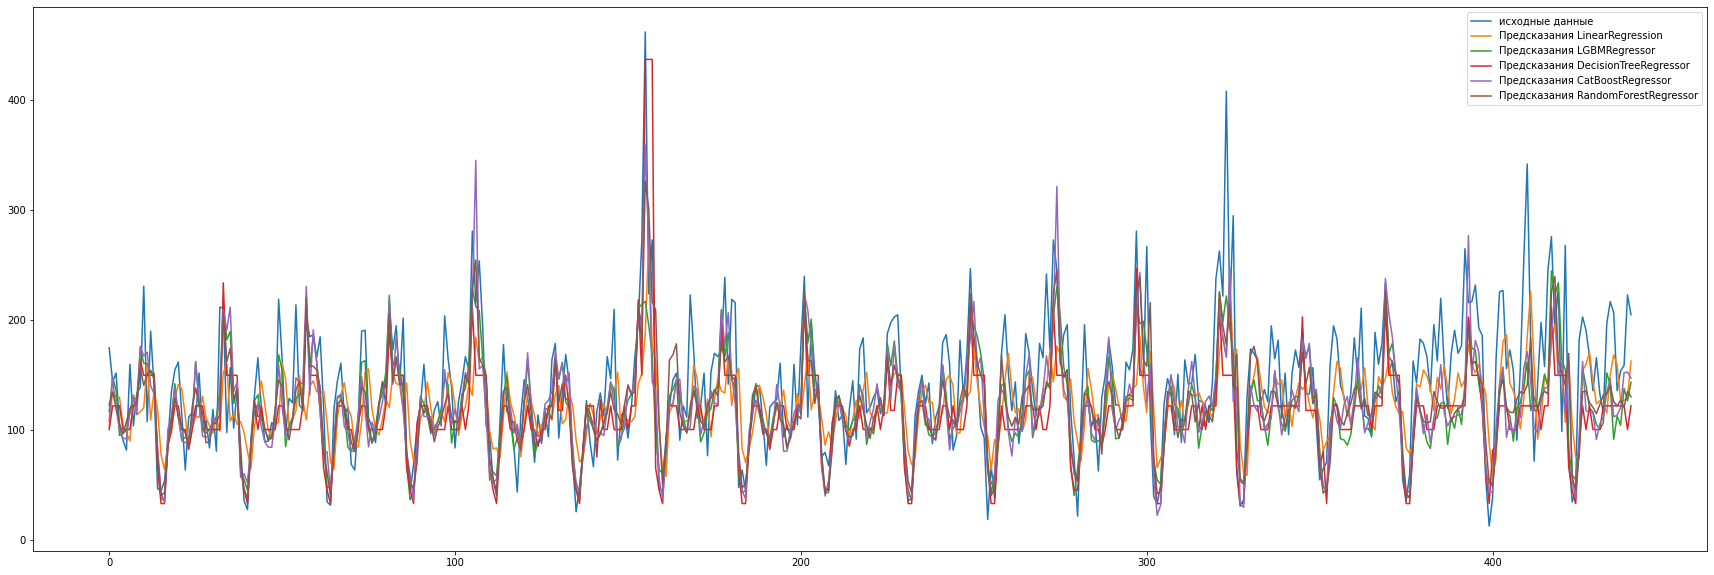

In [26]:
plt.figure(figsize=(30, 10))
plt.plot(test['num_orders'].values, label="исходные данные")
plt.plot(pred_linreg_test, label="Предсказания LinearRegression")
plt.plot(pred_lgbmr_test, label="Предсказания LGBMRegressor")
plt.plot(pred_tree_test, label="Предсказания DecisionTreeRegressor")
plt.plot(pred_cat_test, label="Предсказания CatBoostRegressor")
plt.plot(pred_forest_test, label="Предсказания RandomForestRegressor")
plt.legend(loc="best")
plt.show()

### Вывод: 

Модели обучили, проверили данные на тестовой выборке и увидели, что модели LGBMRegressor, CatBoostRegressor и RandomForestRegressor показывают хорошие результаты метрики RMSE, которые не превышают 48.